In [0]:
# imports
import json
import pprint
from google.colab import files
import urllib.request
import time
from IPython.display import clear_output, display, Audio, Image

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
# load your authentication, with information for both Spotify and Instagram
uploaded = files.upload()

Saving severity_series.csv to severity_series.csv


In [0]:
#convert uploaded file to dataframe type
import io
#df = pd.read_csv(io.BytesIO(uploaded['vix_2011_2019.csv'])) #change the filename in here
df = pd.read_csv(io.BytesIO(uploaded['severity_series.csv']))
# Dataset is now stored in a Pandas Dataframe

In [24]:
df.head()

,Unnamed: 0,Year,Mean,Median,Std,Whisker_3,Quantile_3,Quantile_1,Whisker_1
0,1,1984,0.004020,-0.049409,0.748671,1.575786,0.190708,-0.236310,-1.711800
1,2,1985,-0.261951,-0.044111,1.253261,1.322282,0.153890,-0.646330,-2.555514
2,3,1986,0.381392,0.295690,0.579297,1.181640,0.805690,0.015815,-0.474670
3,4,1987,0.458862,0.345590,0.483696,1.238700,0.865150,0.075333,-0.195692
4,5,1988,0.468091,0.351450,0.508264,1.399200,0.837320,0.068159,-0.185650


In [0]:
df.drop(['Unnamed: 0', 'Median', 'Std', 'Whisker_3', 'Quantile_3', 'Quantile_1', 'Whisker_1'], axis=1, inplace=True)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
Year    34 non-null int64
Mean    34 non-null float64
dtypes: float64(1), int64(1)
memory usage: 624.0 bytes


In [27]:
#df['Date'] = pd.to_datetime(df['Date'])
#df = df.set_index(['Date'], drop=True)
df.head(10)

,Year,Mean
0,1984,0.004020
1,1985,-0.261951
2,1986,0.381392
3,1987,0.458862
4,1988,0.468091
5,1989,0.825976
6,1990,0.702704
7,1991,0.366159
8,1992,0.531207
9,1993,-0.025997


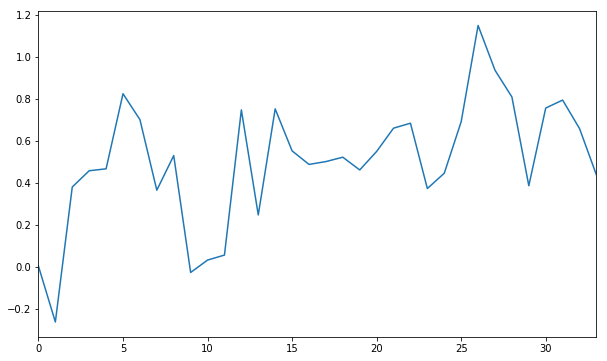

In [28]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df['Mean'].plot();

In [0]:
#split_date = pd.Timestamp('2018-01-01')
split_date = 24

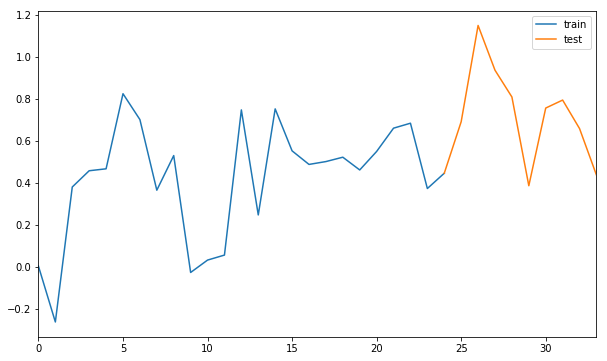

In [30]:
df =  df['Mean']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [0]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [0]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

# **NN**

In [34]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)







Epoch 1/100
24/24 [==============================] - 1s 23ms/step - loss: 0.3577
Epoch 2/100
24/24 [==============================] - 0s 959us/step - loss: 0.3049
Epoch 3/100
24/24 [==============================] - 0s 1ms/step - loss: 0.2679
Epoch 4/100
24/24 [==============================] - 0s 947us/step - loss: 0.2418
Epoch 5/100
24/24 [==============================] - 0s 1ms/step - loss: 0.2237
Epoch 6/100
24/24 [==============================] - 0s 927us/step - loss: 0.2117
Epoch 7/100
24/24 [==============================] - 0s 851us/step - loss: 0.2039
Epoch 8/100
24/24 [==============================] - 0s 1ms/step - loss: 0.1990
Epoch 9/100
24/24 [==============================] - 0s 883us/step - loss: 0.1959
Epoch 10/100
24/24 [==============================] - 0s 1ms/step - loss: 0.1940
Epoch 11/100
24/24 [==============================] - 0s 1ms/step - loss: 0.1928
Epoch 12/100
24/24 [==============================] - 0s 970us/step - loss: 0.1920
Epoch 13/100
24/24

In [35]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.201
The R2 score on the Test set is:	-1.085


# **LSTM**
When constructing LSTM (Long short-term memory), we will use pandas shift function that shifts the entire column by 1. In the below code snippet, we shifted the column down by 1. Then we will need to convert all our input variables to be represented in a 3D vector form.

In [39]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [36]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (24, 1, 1)
Test shape:  (9, 1, 1)


In [37]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
24/24 [==============================] - 1s 28ms/step - loss: 0.2911
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2761
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2629
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2516
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2423
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2348
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2287
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2239
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2201
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2172
Epoch 11/100
24/24 [==============================] - 0s 2ms/step - loss: 0.2149
Epoch 12/100
24/24 [===

In [38]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.159
The R2 score on the Test set is:	-0.951


In [39]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

9/9 [==============================] - 0s 13ms/step
NN: 0.344893
LSTM: 0.322823


In [0]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

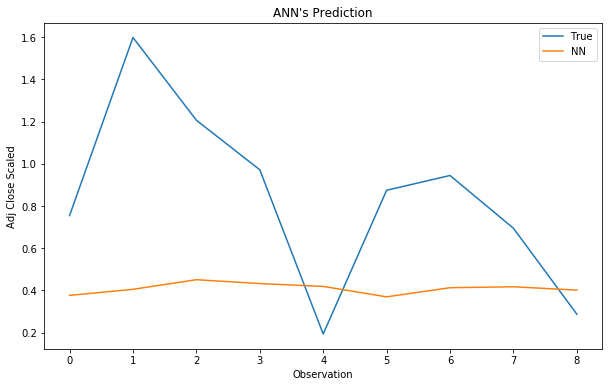

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

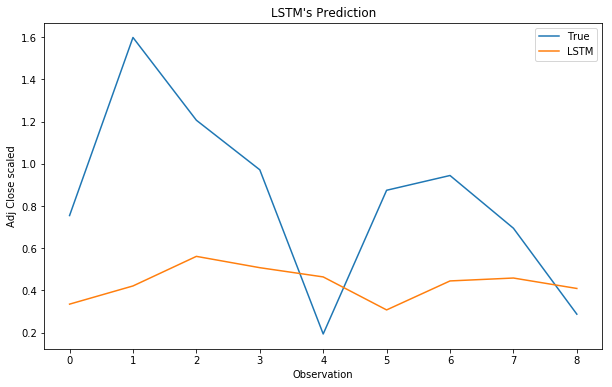

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();